## Imports and paths

In [49]:
import os
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.io import fits

# define environment before importing any DRP related modules
os.environ["LVMCORE_DIR"] = "/Users/droryn/prog/lvm/lvmcore"
os.environ["LVM_MASTER_DIR"] = "/Users/droryn/work/LVM/data/calib"
os.environ["SAS_BASE_DIR"] = "/Users/droryn/work/LVM/data/sas"
os.environ["LVM_DATA_S"] = "/Users/droryn/work/LVM/data/sas/sdsswork/data/lvm/lco"
# os.environ["LVM_SPECTRO_REDUX"] = "/Users/droryn/work/LVM/data/redux"
ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")

GAIA_DIR = "/Users/droryn/work/LVM/data/redux/gaia/"

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp


In [ ]:
drp.get_frames_metadata(mjd=60204, overwrite=True)
#sci_metadata = md.get_metadata(tileid="*", mjd="*", expnum=3793, imagetyp="object")
%timeit qdrp.quick_reduction(["-e", 5063, "-f"])

## Load GAIA Spectrum

In [26]:

def get_gaia_spec(gaia_id):
    # https://gea.esac.esa.int/archive/

    data = np.genfromtxt(GAIA_DIR+'XP_SAMPLED-Gaia DR3 '+gaia_id+'.csv', delimiter=',')
    #data = np.genfromtxt(GAIA_DIR+'XP_SAMPLED-Gaia DR3 5010284310919786496.csv', delimiter=',')
    # in W/m^2/nm
    wave = data[1:,4] * 10   # convert to A
    flux = data[1:,5] * 1e7 / 100**2 / 10 # covert from W/m^2/nm to ergs/s/cm^2/A
    dflux = data[1:,6] * 1e7 / 100**2 / 10
    return wave,flux,dflux

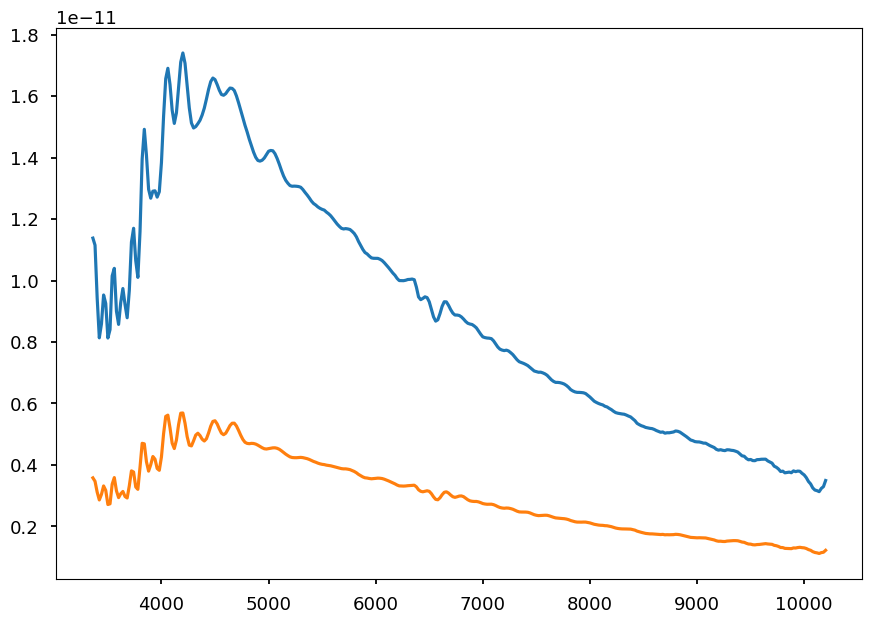

In [27]:
from scipy.optimize import curve_fit
def blackbody_lam(lam, A, T):
    """ Blackbody as a function of wavelength (Angstrom) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    from scipy.constants import h,k,c
    lam = 1e-10 * lam # convert to metres
    return A * 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

def plot_gaia(gaia_ids):
    for g in gaia_ids:
        w,f,d = get_gaia_spec(g)
        plt.plot(w, f)
        # popt, pcov = curve_fit(blackbody_lam, w, f, p0=(1e-11, 6000))
        # plt.plot(w, blackbody_lam(w, popt[0], popt[1]))
        # print(popt)

plot_gaia(['5010284310919786496','6813658512058329344'])

## Load fiber spectra from 4 telescope std star test

In [36]:
from scipy.ndimage import median_filter

def moving_average(x, w=101):
    m = np.isfinite(x)
    if np.all(~m):
        return x
    y = x.copy()
    y[m] = np.convolve(x[m], np.ones(w), 'same')/w
    #y[m] = median_filter(x[m], w)
    return y

def get_fiber_data(mjd, frames):
    s = []
    secz = []
    fibs = []
    for fiber,frame in enumerate(frames):
        with fits.open('/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/'+mjd+'/'+frame) as hdul:
            data = hdul[1].data
            mask = hdul[3].data
            data[np.where(mask)] = np.nan
            w = hdul[4].data
            am = hdul[0].header['TESCIAM']
            # exptime = hdul[0].header['EXPTIME']
            # data /= exptime
        
        fiber = fiber%12
        fiber_str = f"P1-{fiber+1}"
        #select fiber for correct spectrograph for science and sky telescopes
        if (fiber == 0 or fiber == 3 or fiber == 6 or fiber == 9 ):
            fiber_sci = f"S1-300"
            fiber_skye = f"B1-1"
            fiber_skyw = f"A1-1"
        elif (fiber == 1 or fiber == 4 or fiber == 7 or fiber == 10 ):
            fiber_sci = f"S2-300"
            fiber_skye = f"B2-1"
            fiber_skyw = f"A2-1"
        elif (fiber == 2 or fiber == 5 or fiber == 8 or fiber == 11 ):
            fiber_sci = f"S3-300"
            fiber_skye = f"B3-12"
            fiber_skyw = f"A3-12"

        f1 = drp.fibermap.data[drp.fibermap.data['orig_ifulabel'] == fiber_sci]
        f2 = drp.fibermap.data[drp.fibermap.data['orig_ifulabel'] == fiber_skye]
        f3 = drp.fibermap.data[drp.fibermap.data['orig_ifulabel'] == fiber_skyw]
        f4 = drp.fibermap.data[drp.fibermap.data['orig_ifulabel'] == fiber_str]
        for f in [f1, f2, f3, f4]:
            i = f['fiberid'][0]-1
            if i != 1297 and np.any(np.isfinite(data[i,:])):
                #zero = (data[i,:]<5) | (data[i]>250)
                #data[i,zero] = np.nan
                d = moving_average(data[i,:], 100)
                s.append(d)
                secz.append(am)
                fibs.append(f)

    # extinction correct the spectra
    txt = np.genfromtxt('/Users/droryn/work/LVM/data/redux/gaia/lco_extinction.txt')
    lext, ext = txt[:,0], txt[:,1]
    ext = np.interp(w, lext, ext)
    for i in range(len(s)):
        s[i] = s[i]*10**(0.4*ext*secz[i])

    return s, w, secz, fibs


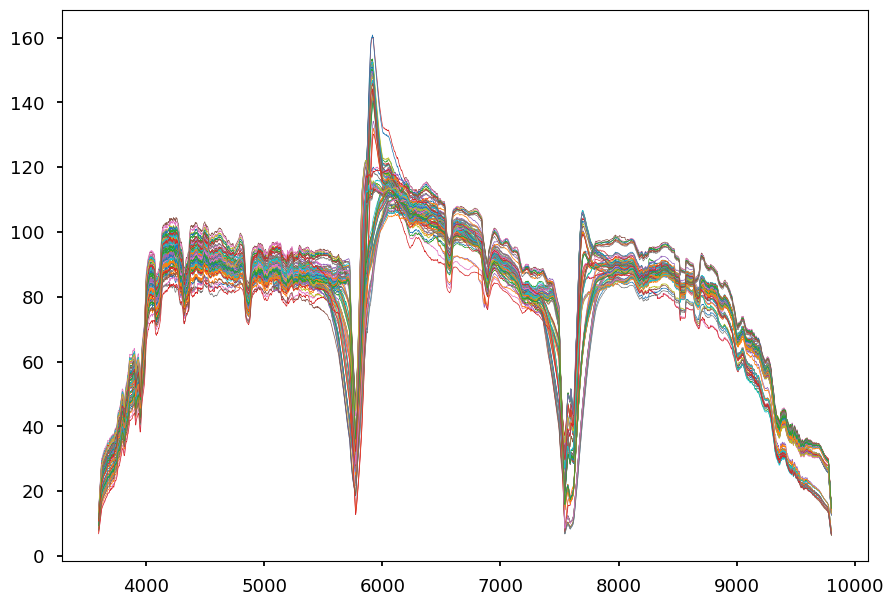

In [54]:
frames04 = ['lvmCFrame-00005063.fits', 'lvmCFrame-00005064.fits', 'lvmCFrame-00005065.fits', 'lvmCFrame-00005066.fits', 'lvmCFrame-00005067.fits',
            'lvmCFrame-00005068.fits', 'lvmCFrame-00005069.fits', 'lvmCFrame-00005070.fits', 'lvmCFrame-00005071.fits', 'lvmCFrame-00005072.fits',
            'lvmCFrame-00005073.fits', 'lvmCFrame-00005074.fits', 'lvmCFrame-00005075.fits', 'lvmCFrame-00005076.fits', 'lvmCFrame-00005077.fits',
            'lvmCFrame-00005078.fits', 'lvmCFrame-00005079.fits', 'lvmCFrame-00005080.fits', 'lvmCFrame-00005081.fits', 'lvmCFrame-00005082.fits',
            'lvmCFrame-00005083.fits', 'lvmCFrame-00005084.fits', 'lvmCFrame-00005085.fits', 'lvmCFrame-00005086.fits']

s, w, secz, fibs = get_fiber_data('60204', frames04)

for i in range(len(s)):
    if fibs[i]['telescope']=='Spec':
        plt.plot(w, 1.0*s[i], linewidth=0.5)
    else:
        plt.plot(w, s[i], linewidth=0.5)


## Calibration and Throughput

In [55]:
# convert from flambda to electrons / cm^2/s
#    Input FLAMBDA is in ergs/cm^2/s/A
# Multiply result with collecting area and integration time.
def flambda_to_electrons(wave,flam):
    h = 1.054572e-34*2.*np.pi*1e7  # Planck's constant in erg
    c = 2.997925e+18               # c in A/s
    #number of detected electrons for an object of spectrum flambda
    return flam/(h*c/wave)

def throughput(gaia_id, s, w):
    wave, flux, _ = get_gaia_spec(gaia_id)
    stdflux = flambda_to_electrons(w, np.interp(w, wave, flux))

    c = []
    aper = np.pi*8.05**2 # aperture in cm^2
    for i in range(len(s)):
        c.append(s[i]/aper/stdflux)
    return c

def plot_throughput(mjd, frames, gaiaid):
    GAIA_DIR = "/Users/droryn/work/LVM/data/redux/gaia/"
    data = np.genfromtxt(GAIA_DIR+'lvmi_tput.csv', delimiter=',')
    twave = data[1:,0] * 10   # convert to A
    tput = data[1:,1]

    tels = {'SkyE':'cyan', 'SkyW':'blue', 'Sci':'green', 'Spec':'red'}
    spec = {1:'solid', 2:'dashed', 3:'dashdot'}

    s, w, secz, fibs = get_fiber_data(mjd, frames)
    t = throughput(gaiaid, s, w)

    for i in range(len(t)):
        if fibs[i]['telescope']=='Spec':
            plt.plot(w, 1.0*t[i], linewidth=0.5, color=tels[fibs[i]['telescope'][0]], linestyle=spec[fibs[i]['spectrographid'][0]])
        else:
            plt.plot(w, t[i], linewidth=0.5, color=tels[fibs[i]['telescope'][0]], linestyle=spec[fibs[i]['spectrographid'][0]])
    #plt.plot(twave, tput*1.05, color='black', linewidth='3')
    plt.plot([6000, 7000], [0.35, 0.35],color='black', linewidth=3)
    plt.xlabel('wavelength/A')
    plt.ylabel('throughput')
    plt.ylim(0.0, 1.0)
    plt.grid(visible=True)
    #plt.yscale('log')


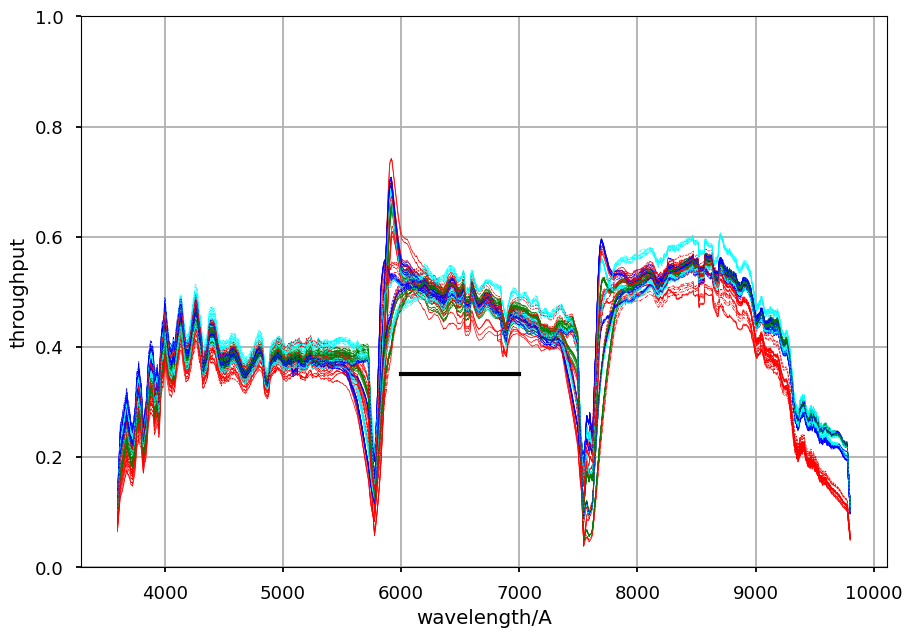

In [56]:
plot_throughput('60204', frames04, '6813658512058329344')

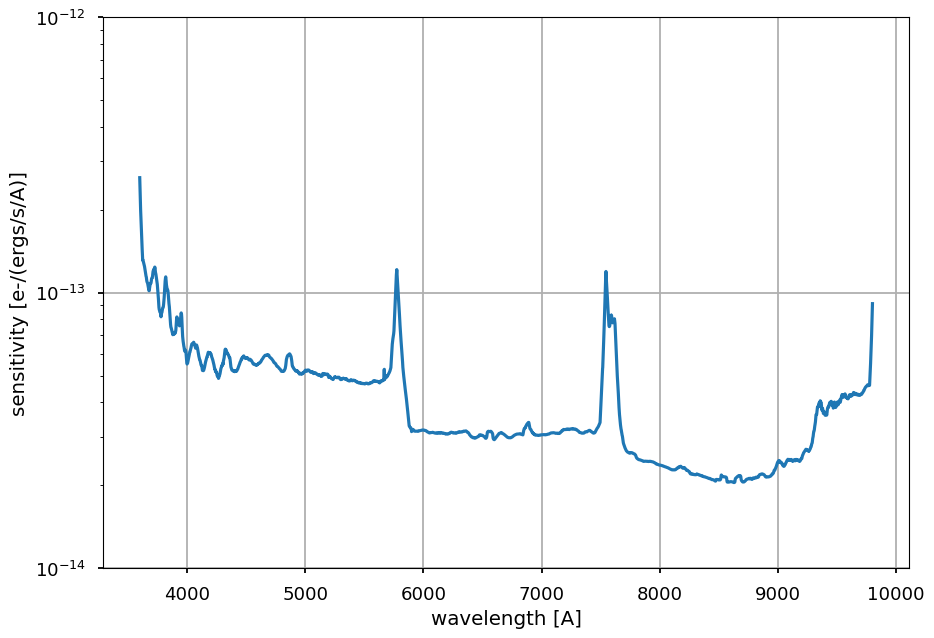

In [57]:
from scipy.ndimage import median_filter

def sensitivity(gaia_id, s, w):
    wave, flux, _ = get_gaia_spec(gaia_id)
    stdflux = np.interp(w, wave, flux)

    c = []
    for i in range(len(s)):
        c.append(stdflux/s[i])
    cc = np.nanmedian(c, axis=0)
    return cc, w

def plot_sensititivy(mjd, frames, gaiaid):
    s, w, secz, fibs = get_fiber_data(mjd, frames)
    t, _ = sensitivity(gaiaid, s, w)
    plt.plot(w, t)
    plt.xlabel('wavelength [A]')
    plt.ylabel('sensitivity [e-/(ergs/s/A)]')
    plt.ylim(1e-14,0.1e-11)
    plt.grid(visible=True)
    plt.semilogy()
    return t

t = plot_sensititivy('60204', frames04, '6813658512058329344')


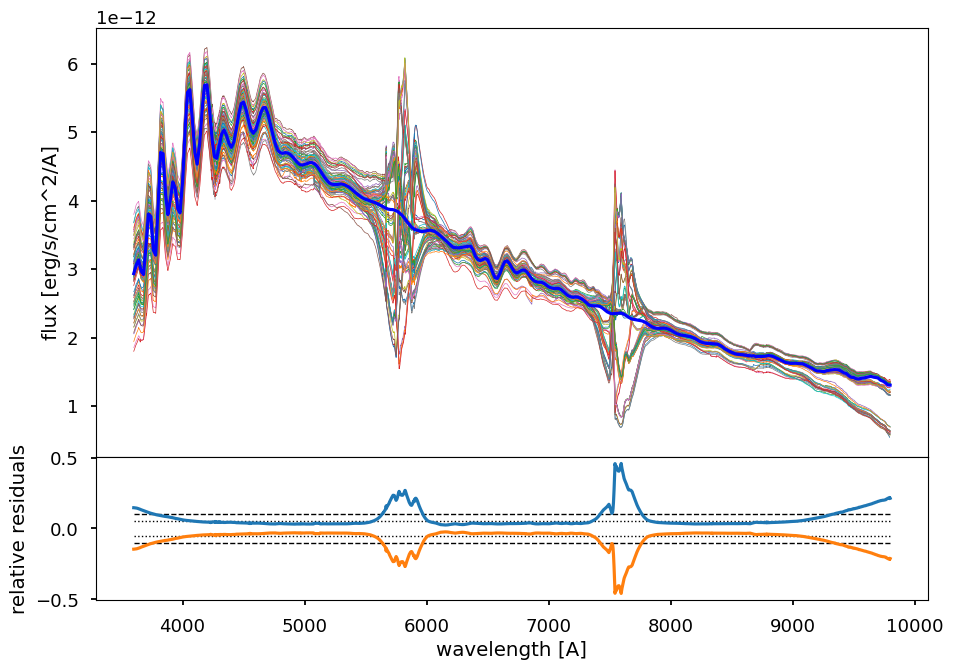

In [58]:
def plot_abs(mjd, frames, gaiaid):
    s, w, secz, fibs = get_fiber_data(mjd, frames)
    t, _ = sensitivity(gaiaid, s, w)
    wave, flux, _ = get_gaia_spec(gaiaid)
    stdflux = np.interp(w, wave, flux)
    plt.subplot
    res = []
    fig1 = plt.figure(1)
    frame1 = fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([])
    for i in range(len(s)):
        plt.plot(w, s[i]*t, linewidth=0.5)
        res.append(s[i]*t/stdflux)
    plt.plot(w,stdflux, color='b')
    plt.ylabel('flux [erg/s/cm^2/A]')
    # resids
    res = np.array(res)
    rms = np.nanstd(res, axis=0)
    frame2 = fig1.add_axes((.1,.1,.8,.2))        
    plt.plot([w[0],w[-1]], [0.05, 0.05], color='k', linewidth=1, linestyle='dotted')
    plt.plot([w[0],w[-1]], [-0.05, -0.05], color='k', linewidth=1, linestyle='dotted')
    plt.plot([w[0],w[-1]], [0.1, 0.1], color='k', linewidth=1, linestyle='dashed')
    plt.plot([w[0],w[-1]], [-0.1, -0.1], color='k', linewidth=1, linestyle='dashed')
    plt.plot(w, rms)
    plt.plot(w, -rms)
    plt.ylabel('relative residuals')
    plt.xlabel('wavelength [A]')


t = plot_abs('60204', frames04, '6813658512058329344')

## Noise around Ha

300.0
22.686249483656265


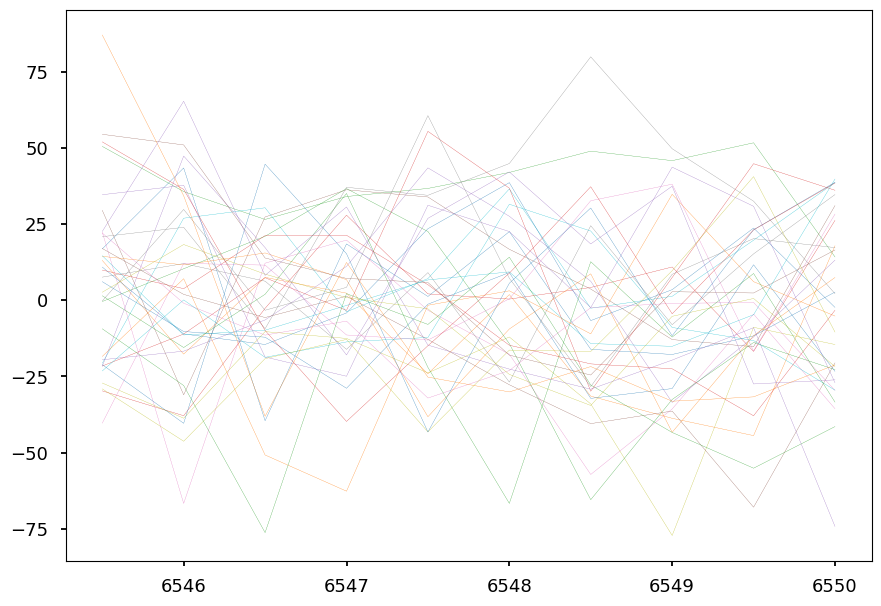

In [8]:
sci = np.where(drp.fibermap.data['targettype'] == 'science')[0]
p=os.getenv('SAS_BASE_DIR')+'/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60184/lvmCFrame-00003904.fits'
with fits.open(p) as hdul:
    print(hdul[0].header['EXPTIME'])
    d = hdul[1].data
    w = hdul[4].data
    a = np.where(w<6546)[0][-1]
    b = np.where(w<6551)[0][-1]
    noise = []
    for i in sci[2::11]:
        if(np.nanmedian(d[i,:]) < 1):
            plt.plot(w[a:b],d[i,a:b], linewidth=0.2)            
            noise.append(np.nanstd(np.convolve(d[i,a:b], np.ones(3), 'same') / 3))
    print(np.nanmean(noise)*np.sqrt(3))
    #plt.ylim(-100,100)



In [10]:
import astropy.units as uu
import astropy.constants as cc

def get_lvmi_eff():
    GAIA_DIR = "/Users/droryn/work/LVM/data/redux/gaia/"
    data = np.genfromtxt(GAIA_DIR+'lvmi_tput.csv', delimiter=',')
    twave = data[1:,0]
    tput = data[1:,1]
    return twave, tput

__twave, __tput = get_lvmi_eff()

def thpt_function_nm(l):
    return np.interp(l.to(uu.nm).value, __twave, __tput)

def A_tel():
    return np.pi*(16.1/2*uu.cm)**2

def f_lambda_to_DN(ll, f_lambda, dl, exptime):
    """ Convert f_lambda [spectral density] to e-
    Args:
        ll[N]: Array of wavelengths
        f_lambda[N]: Array of f_lambdas [spectral density]
        dl[N]: Delta wavelength per (likely) pixel
        exptime: exposure time
    """    
    epp = cc.h*cc.c/ll

    return (f_lambda * exptime * A_tel() * dl * thpt_function_nm(ll) / epp).decompose()
    
fl = uu.erg/uu.s/uu.cm**2/uu.angstrom
q = f_lambda_to_DN(500*uu.nm, 1*fl, 1*uu.angstrom, 900*uu.s)
q

<Quantity 1.70639331e+16>

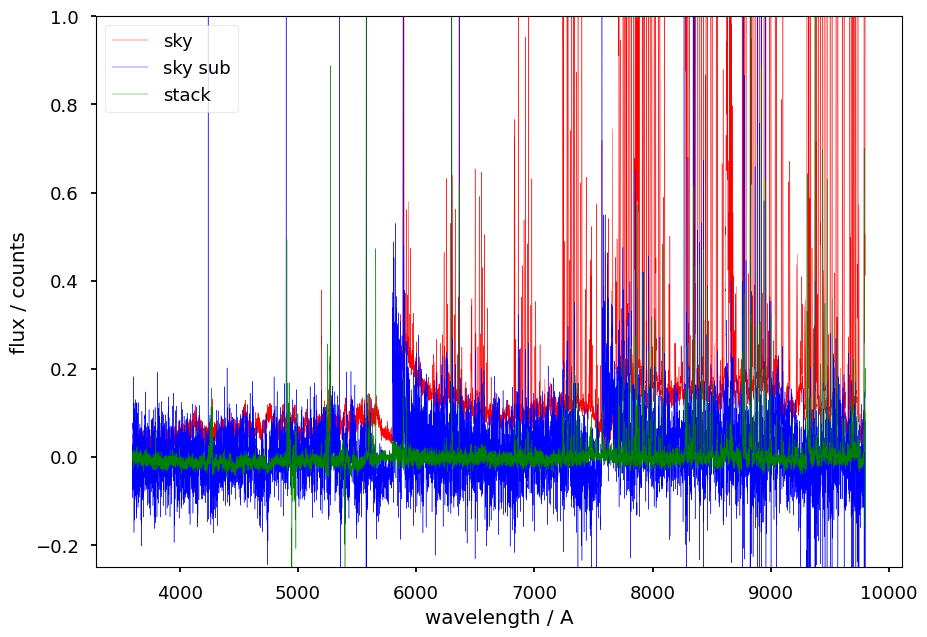

In [49]:
dir = "/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/"
with fits.open(dir+"lvmCFrame-00005063.fits") as hdub:
    w = hdub['WAVE'].data
    slit = Table(hdub['SLITMAP'].data)
    sci = np.where(slit['telescope'] == 'Sci')[0]
    sky = np.where(slit['telescope'] == 'SkyE')[0]
    s = hdub['SKY'].data[sky]
    f = hdub['FLUX'].data[sci]
    ff = np.nansum(f[0:1000:,5000:7000], axis=1)
good = np.where(ff<50)[0]
medsub = f[good,:]
ssky = s[2,:]
stack = np.nanmean(medsub, axis=0)
plt.plot(w, ssky, 'r-', linewidth=0.3, label='sky')
plt.plot(w, f[good,:][1], 'b-', linewidth=0.3, label='sky sub')
plt.plot(w, stack, 'g-', linewidth=0.3, label='stack')
plt.xlabel('wavelength / A')
plt.ylabel('flux / counts')
plt.ylim(-0.25, 1)
plt.legend()

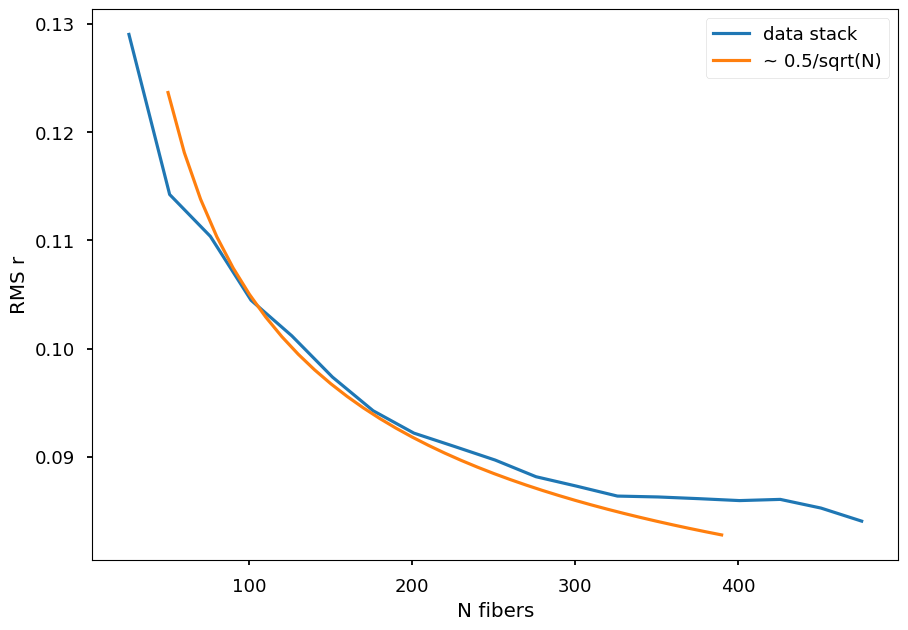

In [19]:
dir = "/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/"
with fits.open(dir+"lvmCFrame-00005063.fits") as hdub:
    w = hdub['WAVE'].data
    slit = Table(hdub['SLITMAP'].data)
    sci = np.where(slit['telescope'] == 'Sci')[0]
    sky = np.where(slit['telescope'] == 'SkyE')[0]
    s = hdub['SKY'].data[sky]
    f = hdub['FLUX'].data[sci]
    ff = np.nansum(f[0:1000:,5000:7000], axis=1)
good = np.where(ff<50)[0]
medsub = f[good,:]
ssky = s[2,:]
rmsr = []
N = []
for i in range(1, 500, 25):
    rmsr.append(np.nanstd(np.nanmean(medsub[1:i,:], axis=0)[5000:7000]))
    N.append(i)

plt.plot(N, rmsr, label='data stack')
plt.xlabel('N fibers')
plt.ylabel('RMS r')
# plt.semilogx()
a = np.arange(50,400,10)
plt.plot(a, 0.45/np.sqrt(a)+0.06, label='~ 0.5/sqrt(N)')
plt.legend()


## Convolving to GAIA BPRP

In [54]:
from scipy.interpolate import interp1d
from scipy.signal import gaussian
import types

def calculate_mean_lsf():
	dir = ORIG_MASTER_DIR+'/60177'
	with fits.open('lvm-mlsf_neon_hgne_argon_xenon-b1.fits') as f:
		d = f[0].data
		d1 = np.nanmedian(d, axis=0)

def kernel(sigma):
	M = int(3*sigma)
	G = gaussian(M,sigma,sym=True)
	return G/np.sum(G)

def varconvolve(x,y,kernel,var,oversample=1,mode='same'):
	"""
	x: an array with x coordinates of the points, must be uniformly sampled
	y: an array with y coordinates of the points
	kernel: name of the function that describes the kernel. Must have one argument, the width of the kernel in x units
	var: a function or array that returns the kernel width in one point.
	"""

	if isinstance(var, (types.FunctionType)):
		pass
	elif isinstance(var, (list, tuple, np.ndarray)):
		var=interp1d(x,var)
	else:
		raise RuntimeError('var must be a function, a list, a tuple, or an ndarray')

	x_new=[x[0]]
	n, m = 0, np.max(var(x))
	sampl = x[1] - x[0]
	while x_new[n]+var(x_new[n])/m/oversample*sampl<=x[-1]:
		x_new.append(x_new[n]+var(x_new[n])/m/oversample*sampl)
		n+=1
	x_new.append(x_new[n]+var(x_new[n])/m/oversample*sampl)

	if len(kernel(m*oversample/sampl))>len(x_new):
		raise RuntimeError('Kernel is larger than the data range.')

	y_new=np.interp(x_new,x,y)
	y_con=np.convolve(y_new,kernel(m*oversample/sampl),mode=mode)
	y_out=np.interp(x,x_new,y_con)

	return y_out

def get_lvm_sens():
    GAIA_DIR = "/Users/droryn/work/LVM/data/redux/gaia/"
    data = np.genfromtxt(GAIA_DIR+'lvm_sensitivity.txt')
    twave = data[1:,0]
    tput = data[1:,1]
    return twave, tput


def ccc():
	tw,tp = get_lvm_sens()
	gw, gs, _ = get_gaia_spec('6813658512058329344')
	plt.plot(gw, gs)
	plt.plot(w, s[0]*np.interp(w, tw, tp), linewidth=1)
ccc()

[ERROR]: Traceback (most recent call last):
  File "/opt/miniconda/envs/lvmdrp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_74722/3874944526.py", line 61, in <module>
    ccc()
  File "/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_74722/3874944526.py", line 58, in ccc
    gw, gs, _ = get_gaia_spec('6813658512058329344')
NameError: name 'get_gaia_spec' is not defined



## Calibrate using 12 standard stars

[WARNING]: Tried to get polar motions for times before IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level. Please check your astropy.utils.iers.conf.iers_auto_url and point it to a newer version if necessary. (AstropyWarning)


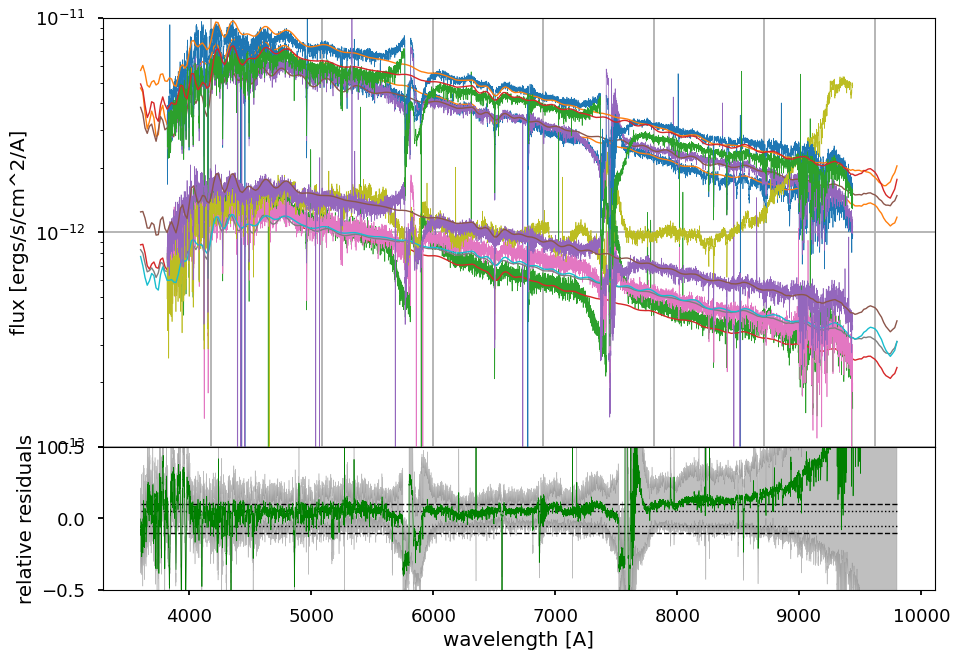

In [23]:
import os.path as path
import requests
from gaiaxpy import calibrate
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from scipy import interpolate
from scipy.ndimage import median_filter
from lvmdrp.core.constants import SPEC_CHANNELS
from lvmdrp.external import ancillary_func
from scipy import signal

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
GAIA_CACHE_DIR = ORIG_MASTER_DIR+'/gaia_cache/'

def interpolate_mask(x, y, mask, kind='linear', fill_value=0):
    """
    :param x, y: numpy arrays, samples and values
    :param mask: boolean mask, True for masked values
    :param method: interpolation method, one of linear, nearest, 
    nearest-up, zero, slinear, quadratic, cubic, previous, or next.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    if not np.any(mask):
        return y
    known_x, known_v = x[~mask], y[~mask]
    missing_x = x[mask]
    missing_idx = np.where(mask)

    f = interpolate.interp1d(known_x, known_v, kind=kind, fill_value=fill_value)
    yy = y.copy()
    yy[missing_idx] = f(missing_x)

    return yy

def get_sky_mask_uves(w, width=3, threshold=2):
    """
    Generate a mask for the bright sky lines. 
    mask every line at +-width, where width in same units as w (Angstroms)
    Only lines with a flux larger than threshold (in 10E-16 ergs/cm^2/s/A) are masked
    The line list is from https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html
    """
    txt = np.genfromtxt(GAIA_DIR+'UVES_sky_lines.txt')
    skyw, skyf = txt[:,1], txt[:,4]
    #plt.plot(skyw, skyw*0, 'k.')
    #plt.plot(skyw, skyf, 'k.')
    select = (skyf>threshold)
    lines = skyw[select]
    # do NOT mask Ha if it is present in the sky table
    ha = (lines>6562) & (lines<6564)
    lines = lines[~ha]
    mask = np.zeros_like(w, dtype=bool)
    if width > 0.0:
        for line in lines :
            if (line<=w[0]) or (line>=w[-1]):
                continue
            ii=np.where((w>=line-width)&(w<=line+width))[0]
            mask[ii]=True

    return mask

def convolve_to_gaia(x, w=101):
    m = np.isfinite(x)
    if np.all(~m):
        return x
    y = x.copy()
    y[m] = np.convolve(x[m], np.ones(w), 'same')/w
    return y

def moving_median(x, w=101):
    m = np.isfinite(x)
    if np.all(~m):
        return x
    y = x.copy()
    y[m] = median_filter(x[m], w)
    return y


def get_z_continuum_mask(w):
    good = [[9230,9280], [9408,9415], [9464,9472], [9608,9512], [9575,9590], [9593,9603], [9640,9650], [9760,9775]]
    mask = np.zeros_like(w, dtype=bool)
    for r in good :
        if (r[0]<=w[0]) or (r[1]>=w[-1]):
            continue
        ii=np.where((w>=r[0])&(w<=r[1]))[0]
        mask[ii]=True

    # do not mask before first region
    mask[np.where(w<=good[0][0])] = True
    return mask
 
def mean_absolute_deviation(vals):
    '''
    Robust estimate of RMS
    - see https://en.wikipedia.org/wiki/Median_absolute_deviation
    '''
    mval = np.nanmedian(vals)
    rms = 1.4826*np.nanmedian(np.abs(vals-mval))
    return mval, rms
    #ok=np.abs(vals-mval)<4*rms

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    normal_cutoff = float(cutoff_freq) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass') 
    y = signal.filtfilt(b, a, data)
    return y

def filter_channel(lam0, lam1, w, f, k=3):
    c = np.where(np.isfinite(f) & (w>=lam0) & (w<lam1))
    s = butter_lowpass_filter(f[c], 0.01, 2)
    res = s - f[c]
    #plt.plot(w[c], f[c], 'k.')
    #plt.plot(w[c], s, 'b-')
    mres, rms = mean_absolute_deviation(res)
    good = np.where(np.abs(res-mres)<k*rms)
    #plt.plot(w[c][good], f[c][good], 'r.', markersize=5)
    return w[c][good], f[c][good]

def retrieve_header_stars(in_rss):
    '''
    Retrieve fiber, Gaia ID, exposure time and airmass for the 12 standard stars in the header.
    return a list of tuples of the above quatities.
    '''
    lco = EarthLocation(lat=-29.008999964*u.deg, lon=-70.688663912*u.deg, height=2800*u.m)   
    with fits.open(dir+in_rss) as hdub:
        h = hdub[0].header
    # retrieve the data for the 12 standards from the header
    stddata = []
    for i in range(12):
        stdi = 'STD'+str(i+1)
        if h[stdi+'ACQ']:
            gaia_id = h[stdi+'ID']
            fiber = h[stdi+'FIB']
            obstime = Time(h[stdi+'T0'])
            exptime = h[stdi+'EXP']
            c = SkyCoord(float(h[stdi+'RA']), float(h[stdi+'DE']), unit="deg") 
            stdT = c.transform_to(AltAz(obstime=obstime,location=lco))  
            secz = stdT.secz.value
            #print(gid, fib, et, secz)
        stddata.append((fiber, gaia_id, exptime, secz))
    return stddata


def get_std_spectral_data(frame, plot=True):
    '''
    Get the observed spectra and the gaia spectra of standard stars given an lvmCFrame
    '''
    stds = ancillary_func.retrieve_header_stars(frame)

    with fits.open(dir+frame) as hdub:
        h = hdub[0].header
        d = hdub['FLUX'].data
        w = hdub['WAVE'].data
        slit = Table(hdub['SLITMAP'].data)
    sci_exptime = h['EXPTIME']
    sci_secz = h['TESCIAM']

    # extinction
    txt = np.genfromtxt(GAIA_DIR+'lco_extinction.txt')
    lext, ext = txt[:,0], txt[:,1]
    ext = np.interp(w, lext, ext)

    if plot:
        plt.subplot
        res = []
        fig1 = plt.figure(1)
        frame1 = fig1.add_axes((.1,.3,.8,.6))
        #frame1.set_xticklabels([])

    m = get_sky_mask_uves(w, width=3)
    m2 = get_z_continuum_mask(w)
    for s in stds:
        fiber, gaia_id, exptime, secz = s
        gw, gf = ancillary_func.retrive_gaia_star(gaia_id, GAIA_CACHE_DIR=GAIA_CACHE_DIR)
        fibidx = slit[np.where(slit['orig_ifulabel']==fiber)]['fiberid']
        spec = d[fibidx[0]-1,:]/exptime
        spec = interpolate_mask(w, spec, m, fill_value='extrapolate')
        spec = interpolate_mask(w, spec, ~m2, fill_value='extrapolate')
        spec *= 10**(0.4*ext*secz)
        stdflux = np.interp(w, gw, gf)
        sens = stdflux/spec
        wb, fb = filter_channel(3600, 5775, w, sens, 2)
        wr, fr = filter_channel(5775, 7540, w, sens, 2)
        wz, fz = filter_channel(7540, 9800, w, sens, 2)
        wgood = np.concatenate((wb, wr, wz), axis=None)
        sgood = np.concatenate((fb, fr, fz), axis=None)
        #plt.plot(wgood, sgood, 'r.', markersize=4)
        #plt.ylim(0,0.1e-11)
        s = interpolate.make_smoothing_spline(wgood, sgood, lam=1e4)
        if plot:
            plt.plot(wgood, sgood, linewidth=0.5)
            plt.plot(w, s(w), linewidth=0.5)
            res.append(s(w))

    res = np.array(res)
    rms = np.nanstd(res, axis=0)
    mean = np.nanmean(res, axis=0)

    if plot:
        plt.ylabel('sensitivity [e-/(ergs/s/A)]')
        plt.xlabel('wavelength [A]')
        #plt.ylim(1e-14, 0.1e-11)
        plt.grid(visible=True)
        plt.semilogy()
        frame2 = fig1.add_axes((.1,.1,.8,.2))        
        plt.plot([w[0],w[-1]], [0.05, 0.05], color='k', linewidth=1, linestyle='dotted')
        plt.plot([w[0],w[-1]], [-0.05, -0.05], color='k', linewidth=1, linestyle='dotted')
        plt.plot([w[0],w[-1]], [0.1, 0.1], color='k', linewidth=1, linestyle='dashed')
        plt.plot([w[0],w[-1]], [-0.1, -0.1], color='k', linewidth=1, linestyle='dashed')
        plt.plot(w, rms/mean)
        plt.plot(w, -rms/mean)
        plt.ylim(-0.2, 0.2)
        plt.ylabel('relative residuals')
        plt.xlabel('wavelength [A]')

    return w,mean

def plot_std_spectral(frame):
    '''
    Plot the calibrated standards
    '''
    stds = retrieve_header_stars(frame)

    with fits.open(dir+frame) as hdub:
        #hdub.info()
        h = hdub[0].header
        d = hdub[1].data
        w = hdub[4].data
        slit = Table(hdub[9].data)
    sci_exptime = h['EXPTIME']
    sci_secz = h['TESCIAM']

    plt.subplot
    res = []
    fig1 = plt.figure(1)
    frame1 = fig1.add_axes((.1,.3,.8,.6))
    #frame1.set_xticklabels([])

    m = get_sky_mask_uves(w, width=3)
    m2 = get_z_continuum_mask(w)
    for s in stds:
        fiber, gaia_id, exptime, secz = s
        if fiber=='':
           continue
        try:
            gw, gf = ancillary_func.retrive_gaia_star(gaia_id, GAIA_CACHE_DIR=GAIA_CACHE_DIR)
        except ancillary_func.GaiaStarNotFound as e:
            continue
        fibidx = slit[np.where(slit['orig_ifulabel']==fiber)]['fiberid']
        spec = d[fibidx[0]-1,:]
        plt.plot(w, spec, linewidth=0.5)
        plt.plot(gw, gf, linewidth=1.0)

    plt.ylabel('flux [ergs/s/cm^2/A]')
    plt.xlabel('wavelength [A]')
    plt.ylim(1e-13, 1e-11)
    plt.grid(visible=True)
    plt.semilogy()

    frame2 = fig1.add_axes((.1,.1,.8,.2))   
    resids = []     
    for s in stds:
        fiber, gaia_id, exptime, secz = s
        if fiber=='':
            continue
        try:
            gw, gf = ancillary_func.retrive_gaia_star(gaia_id, GAIA_CACHE_DIR=GAIA_CACHE_DIR)
        except ancillary_func.GaiaStarNotFound as e:
            continue
        fibidx = slit[np.where(slit['orig_ifulabel']==fiber)]['fiberid']
        spec = d[fibidx[0]-1,:]
        resid = (spec - np.interp(w, gw, gf))/np.interp(w, gw, gf)
        #plt.plot(w, resid, linewidth=0.5, alpha=0.2)
        resids.append(resid)
    residsa = np.nanmean(resids, axis=0)
    residsrms = 1.4826*np.nanmedian(np.abs(resids-residsa), axis=0)
    plt.plot([w[0],w[-1]], [0.05, 0.05], color='k', linewidth=1, linestyle='dotted')
    plt.plot([w[0],w[-1]], [-0.05, -0.05], color='k', linewidth=1, linestyle='dotted')
    plt.plot([w[0],w[-1]], [0.1, 0.1], color='k', linewidth=1, linestyle='dashed')
    plt.plot([w[0],w[-1]], [-0.1, -0.1], color='k', linewidth=1, linestyle='dashed')
    plt.fill_between(w, residsa-residsrms, residsa+residsrms, alpha=0.5, color='gray')
    plt.plot(w,residsa,'g-', linewidth=0.5)
    plt.ylim(-0.5, 0.5)
    plt.ylabel('relative residuals')
    plt.xlabel('wavelength [A]')

# master
#dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/'
#plot_std_spectral('lvmCFrame-00006573.fits')
dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60215/'
plot_std_spectral('lvmCFrame-00005684.fits')
#dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60228/'
#plot_std_spectral('lvmCFrame-00006449.fits')

Text(0.5, 1.0, 'HD 60753 -- lvm frame 6573, MJD 6230')

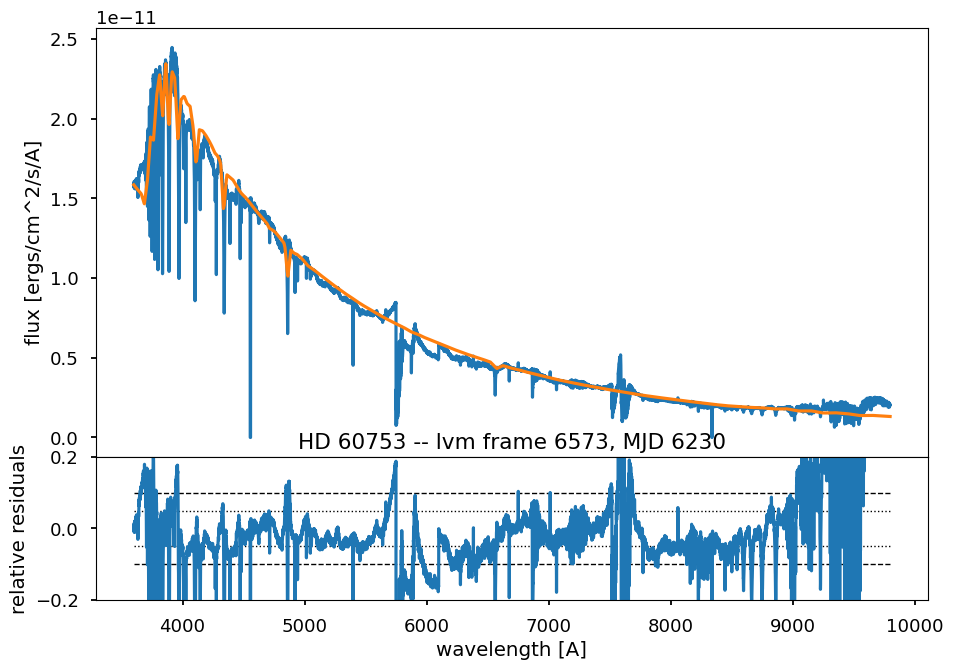

In [21]:
dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/'
frame = 'lvmCFrame-00006573.fits'
stds = retrieve_header_stars(frame)
with fits.open(dir+frame) as hdub:
    h = hdub[0].header
    d = hdub['FLUX'].data
    w = hdub['WAVE'].data
    slit = Table(hdub[9].data)
sci_exptime = h['EXPTIME']
sci_secz = h['TESCIAM']

# extinction
txt = np.genfromtxt(GAIA_DIR+'lco_extinction.txt')
lext, ext = txt[:,0], txt[:,1]
ext = np.interp(w, lext, ext)

plt.subplot
res = []
fig1 = plt.figure(1)
frame1 = fig1.add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([])
fibidx = slit[np.where(slit['orig_ifulabel']=='S1-300')]['fiberid']
spec = d[fibidx[0]-1,:]
spec *= 10**(0.4*ext*(0.5))
spec[5000:8000] *= 1.18
#spec = moving_average(spec, w=51)
good = np.isfinite(spec)
plt.plot(w, spec)

# flux table from https://ftp.eso.org/pub/usg/standards/hststan/
txt = np.genfromtxt(GAIA_DIR+'fhd60753.txt')
lhd, hd = txt[:,0], txt[:,1]
hd60753 = np.interp(w, lhd, hd)*1e-16
plt.plot(w,hd60753)

plt.ylabel('flux [ergs/cm^2/s/A]')
plt.xlabel('wavelength [A]')
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot([w[0],w[-1]], [0.05, 0.05], color='k', linewidth=1, linestyle='dotted')
plt.plot([w[0],w[-1]], [-0.05, -0.05], color='k', linewidth=1, linestyle='dotted')
plt.plot([w[0],w[-1]], [0.1, 0.1], color='k', linewidth=1, linestyle='dashed')
plt.plot([w[0],w[-1]], [-0.1, -0.1], color='k', linewidth=1, linestyle='dashed')
plt.plot(w, (spec-hd60753)/hd60753)
plt.ylim(-0.2, 0.2)
plt.ylabel('relative residuals')
plt.xlabel('wavelength [A]')
plt.title('HD 60753 -- lvm frame 6573, MJD 6230')


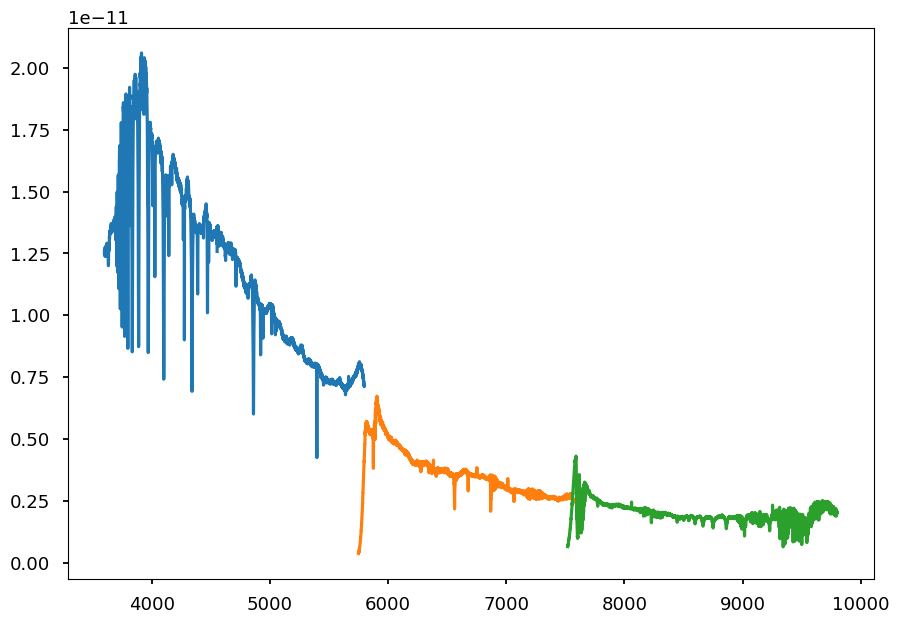

In [21]:
# fluxcal branch
dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/'
fiber = 'S1-300'
with fits.open(dir+'lvmCFrame-00006573.fits') as hdub:
    slit = Table(hdub[9].data)
    #hdub.info()

with fits.open(dir+'ancillary/lvm-object-b-00006573.fits') as hdub:
    b = hdub[0].data
    fibidx = slit[np.where(slit['orig_ifulabel']==fiber)]['fiberid']
    spec = b[fibidx[0]-1,:]
    x = hdub['WAVE'].data
    plt.plot(x,spec)

with fits.open(dir+'ancillary/lvm-object-r-00006573.fits') as hdub:
    b = hdub[0].data
    fibidx = slit[np.where(slit['orig_ifulabel']==fiber)]['fiberid']
    spec = b[fibidx[0]-1,:]
    x = hdub['WAVE'].data
    plt.plot(x,spec)

with fits.open(dir+'ancillary/lvm-object-z-00006573.fits') as hdub:
    b = hdub[0].data
    fibidx = slit[np.where(slit['orig_ifulabel']==fiber)]['fiberid']
    spec = b[fibidx[0]-1,:]
    x = hdub['WAVE'].data
    plt.plot(x,spec)

(1733,)
(772,)


Text(0, 0.5, 'R')

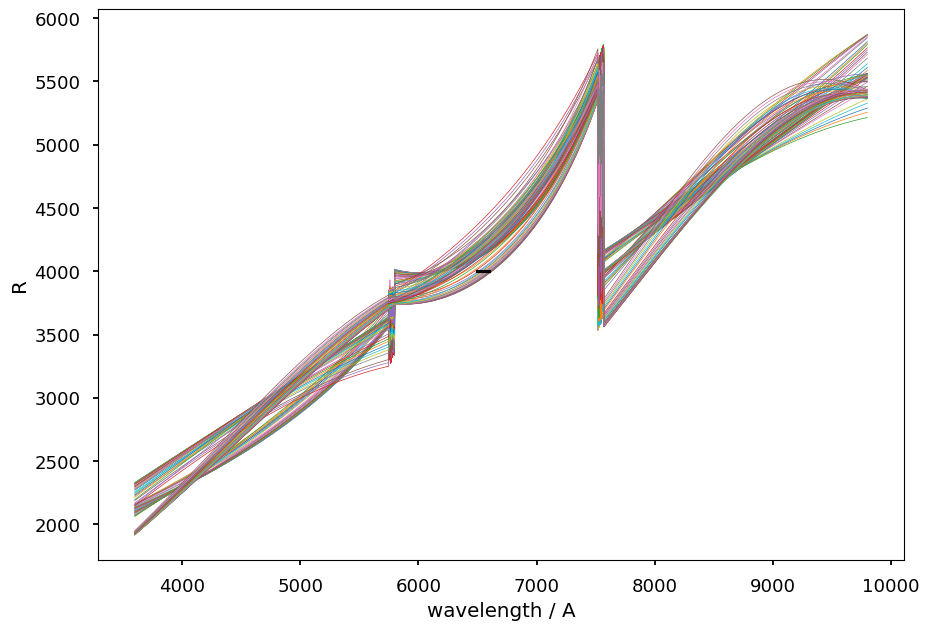

In [62]:
dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60215/'
with fits.open(dir+'lvmCFrame-00005684.fits') as hdub:
    b = hdub['FWHM'].data
    w = hdub['WAVE'].data
    R = w / b
    plt.plot(w, R[::20].T, linewidth=0.5)
plt.plot([6500, 6600], [4000,4000], 'k')
ha = np.where(w>6562)[0][0]
RR = R[:,ha]
print(RR[np.where(RR>4000)].shape)
print(RR[np.where(RR>4200)].shape)
plt.xlabel('wavelength / A')
plt.ylabel('R')


0.030524790119655327


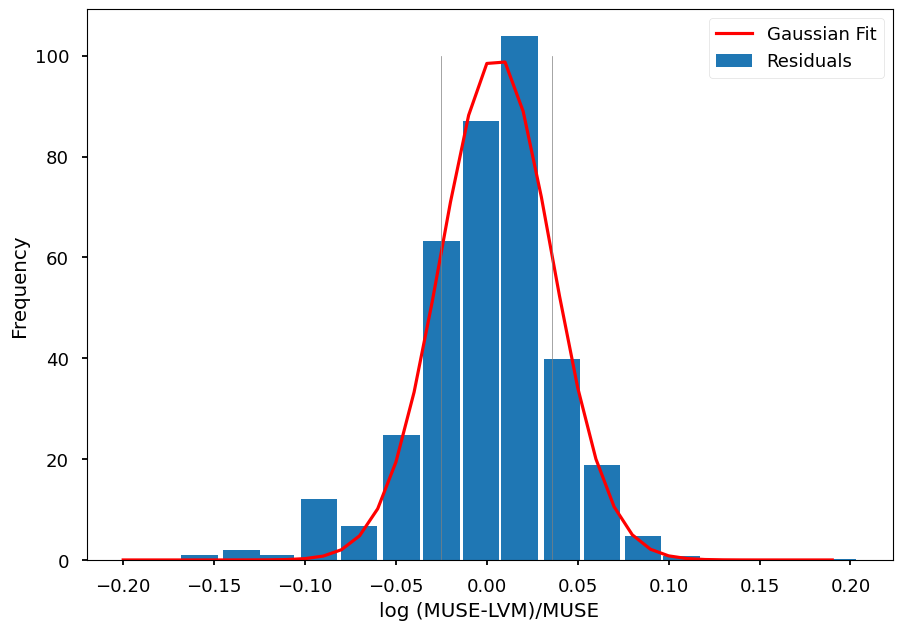

In [49]:
from astropy.modeling import models, fitting

a=[-0.183,-0.158,-0.135,-0.116,-0.0922,-0.0703,-0.0469,-0.0250,-0.00312,0.0180,0.0414,0.0633,0.0859,0.107,0.130,0.154,0.193]
b=[0.000,1.070,1.880,1.070,12.10,6.700,24.70,63.30,87.10,104.0,39.90,18.80,4.830,0.804,0.268,0.268,0.268]

fit = fitting.LevMarLSQFitter()
g = models.Gaussian1D()
g = fit(g, a, b)
plt.figure()
plt.bar(a, b, 0.02, label='Residuals')
x = np.arange(-0.2, 0.2, 0.01)
plt.plot(x, g(x), 'r-', label='Gaussian Fit')
plt.plot([-g.stddev.value+g.mean.value, -g.stddev.value+g.mean.value], [0,100], color='gray', linewidth=0.5)
plt.plot([g.stddev.value+g.mean.value, g.stddev.value+g.mean.value], [0,100], color='gray', linewidth=0.5)
plt.xlabel('log (MUSE-LVM)/MUSE')
plt.ylabel('Frequency')
plt.legend()
print(g.stddev.value)

/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028723/60404/ancillary/lvm-dobject-z3-00015597.fits


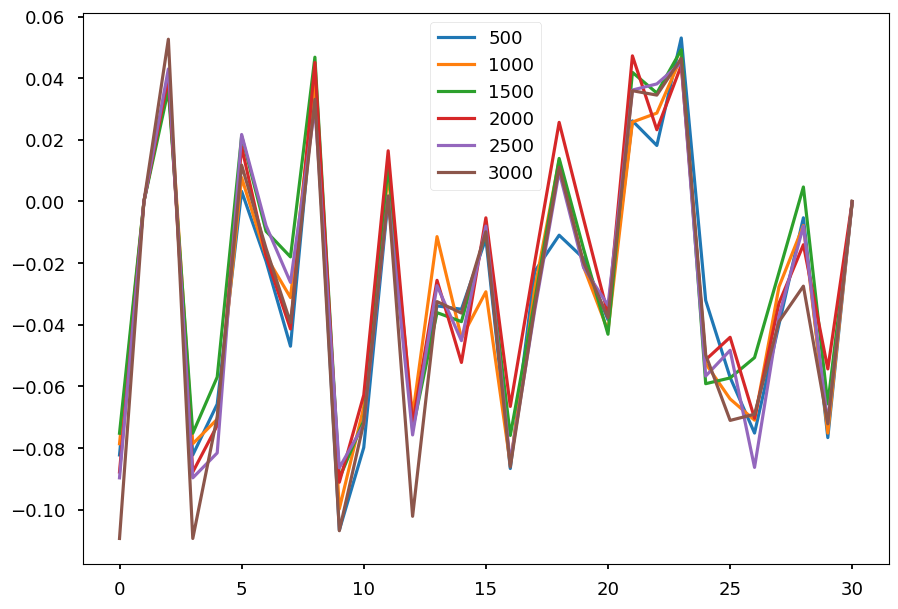

In [163]:
%matplotlib inline
from astropy.io import fits
from lvmdrp.core import spectrum1d
from lvmdrp.functions import imageMethod

dir = '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.2dev/'

import subprocess
camera = 'z3'
result = subprocess.run(['find', dir, '-name', 'lvm-d*-'+camera+'-*.fits'], stdout=subprocess.PIPE)
frames = result.stdout.decode().split('\n')[:-1] # last one is ''
frames = [dir+'1028723/60404/ancillary/lvm-dobject-'+camera+'-00015597.fits', dir+'1052736/60404/ancillary/lvm-dobject-'+camera+'-00015624.fits'] + frames
ref = frames[0]
print(ref)
with fits.open(ref) as hdu1:
    r0 = hdu1['PRIMARY'].data

cols = [500, 1000, 1500, 2000, 2500, 3000]
w = 25
shifts = np.zeros( (len(frames),len(cols)) )
for i,frame in enumerate(frames[1:]):
    with fits.open(frame) as hdu1:
        r1 = hdu1['PRIMARY'].data

    s = imageMethod.measure_y_fiber_image_shift(r0, r1, cols=cols, w=w, shift_range=[-5,5])
    shifts[i,:] = s

for i in range(shifts.shape[1]):
    plt.plot(shifts[:,i], label=str(cols[i]))
plt.legend()